### Neural Networks for Handwritten Digit Recognition, Binary

Prepare neural network to recognize two handwritten digits, zero and one.


### Dataset

You will start by loading the dataset for this task.
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit.
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
        - Each training example becomes a single row in our data matrix `X`.
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X =
\left(\begin{array}{cc}
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\
--- (x^{(m)}) ---
\end{array}\right)$$

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
% matplotlib inline

import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# load dataset
X, y = load_data()

print('Each element is 20 by 20 grid of pixels is “unrolled” into a %d dimensional vector ' % len(X[0]))
print('The first element of X is: ', X[0])

UsageError: Line magic function `%` not found.


In [43]:
print('The first element of y is: ', y[0, 0])
print('The 700s element of y is: ', y[700, 0])

The first element of y is:  0
The 700s element of y is:  1


#### Check the dimensions of your variables
Another way to get familiar with your data is to view its dimensions. Please print the shape of X and y and see how many training examples you have in your dataset.

In [44]:
print('The shape of X is: rows = %d columns = %d' % (X.shape[0], X.shape[1]))
print('The shape of y is: rows = %d columns = %d' % (y.shape[0], y.shape[1]))

The shape of X is: rows = 1000 columns = 400
The shape of y is: rows = 1000 columns = 1


#### Visualizing the Data

You will begin by visualizing a subset of the training set.
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together.
- The label for each image is displayed above the image

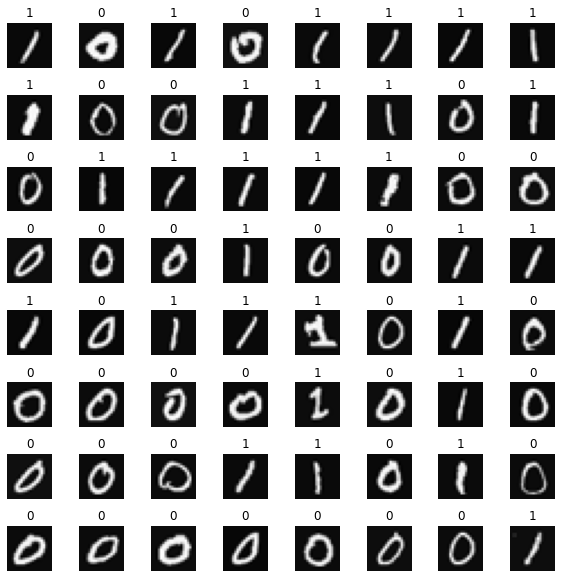

In [45]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Display the label above the image
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()

#### Model representation

The neural network you will use in this assignment is shown in the figure below.
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs

<img src="../../img/2_advanced_learning_algorithms/week1_practice/model_representation.png" width="600">

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3.

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements

    - Therefore, the shapes of `W`, and `b`,  are
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (1,n) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention.

In [46]:
# UNQ_C1
# GRADED CELL: Sequential model

model = Sequential(
    [
        tf.keras.Input(shape=(400,)),  #specify input size
        ### START CODE HERE ###
        Dense(25, activation='sigmoid', name='layer1'),
        Dense(15, activation='sigmoid', name='layer2'),
        Dense(1, activation='sigmoid', name='layer3')
        ### END CODE HERE ###
    ], name="my_model"
)
model.summary()
[layer1, layer2, layer3] = model.layers

#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                10025     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________
W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


#### NumPy Model Implementation (Forward Prop in NumPy)

<img src="../../img/2_advanced_learning_algorithms/week1_practice/numpy_model_implementation.png" width="600">

In [47]:
# UNQ_C2
# GRADED FUNCTION: my_dense

def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    ### START CODE HERE ###
    for j in range(units):
        w = W[:, j]  # Select weights for unit j. These are in column j of W
        z = np.dot(w, a_in) + b[j]  # dot product of w and a_in + b
        a_out[j] = g(z)  # apply activation to z

    ### END CODE HERE ###
    return (a_out)

In [48]:
# Quick Check
x_tst = 0.1 * np.arange(1, 3, 1).reshape(2, )  # (1 examples, 2 features)
W_tst = 0.1 * np.arange(1, 7, 1).reshape(2, 3)  # (2 input features, 3 output features)
b_tst = 0.1 * np.arange(1, 4, 1).reshape(3, )  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)
# UNIT TESTS
#test_c2(my_dense)

[0.54735762 0.57932425 0.61063923]


The following cell builds a three-layer neural network utilizing the my_dense subroutine above.

In [49]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x, W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return (a3)

In [50]:
# We can copy trained weights and biases from Tensorflow.
W1_tmp, b1_tmp = layer1.get_weights()
W2_tmp, b2_tmp = layer2.get_weights()
W3_tmp, b3_tmp = layer3.get_weights()

In [51]:
# make predictions
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print("yhat = ", yhat, " label= ", y[0, 0])
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print("yhat = ", yhat, " label= ", y[500, 0])

yhat =  0  label=  0
yhat =  0  label=  1


###  !Predict using the Neural Network implemented in Numpy!
Run the following cell to see predictions from both the Numpy model and the Tensorflow model. This takes a moment to run.

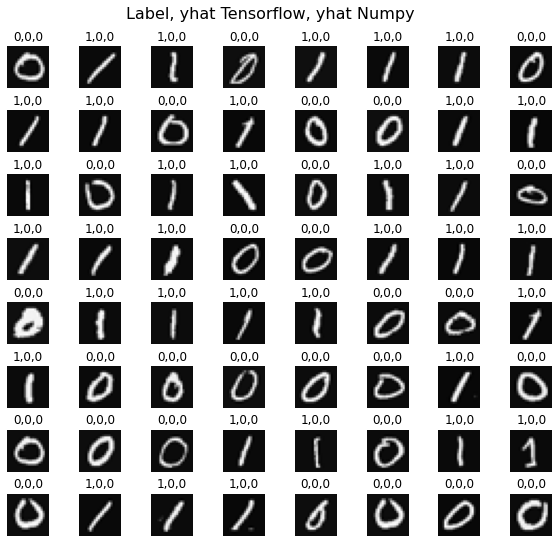

In [52]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])  #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
    my_yhat = int(my_prediction >= 0.5)

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(X[random_index].reshape(1, 400))
    tf_yhat = int(tf_prediction >= 0.5)

    # Display the label above the image
    ax.set_title(f"{y[random_index, 0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

<a name="2.6"></a>
### 2.6 Vectorized NumPy Model Implementation (Optional)
The optional lectures described vector and matrix operations that can be used to speed the calculations.
Below describes a layer operation that computes the output for all units in a layer on a given input example:

<img src="../../img/2_advanced_learning_algorithms/week1_practice/vectorized_numpy.png" width="600">

We can demonstrate this using the examples `X` and the `W1`,`b1` parameters above. We use `np.matmul` to perform the matrix multiply. Note, the dimensions of x and W must be compatible as shown in the diagram above.

In [53]:
x = X[0].reshape(-1, 1)  # column vector (400,1)
z1 = np.matmul(x.T, W1) + b1  # (1,400)(400,25) = (1,25)
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


You can take this a step further and compute all the units for all examples in one Matrix-Matrix operation.

<img src="../../img/2_advanced_learning_algorithms/week1_practice/matrix_matrix_operations.png" width="600">

The full operation is $\mathbf{Z}=\mathbf{XW}+\mathbf{b}$. This will utilize NumPy broadcasting to expand $\mathbf{b}$ to $m$ rows. If this is unfamiliar, a short tutorial is provided at the end of the notebook.

Below, compose a new my_dense_v subroutine that performs the layer calculations for a matrix of examples. This will utilize np.matmul().

In [54]:
# UNQ_C3
# GRADED FUNCTION: my_dense_v

def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (tf.Tensor or ndarray (m,j)) : m examples, j units
    """
    ### START CODE HERE ###
    Z = np.matmul(A_in,W) + b
    A_out = g(Z)
    ### END CODE HERE ###
    return(A_out)

X_tst = 0.1*np.arange(1,9,1).reshape(4,2) # (4 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3) # (1, 3 features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


The following cell builds a three-layer neural network utilizing the my_dense_v subroutine above.

In [55]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return(A3)

We can again copy trained weights and biases from Tensorflow.

In [56]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

Let's make a prediction with the new model. This will make a prediction on all of the examples at once. Note the shape of the output.

In [57]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

(1000, 1)